## Multi-task problem: colored MNIST

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, TensorDataset


import matplotlib.pyplot as plt

%matplotlib inline

### Colored [MNIST Dataset](https://pytorch.org/docs/stable/torchvision/datasets.html#mnist)
* Handwritten digits with 10 classes
* Size of each image: 28x28 pixels 
* 50 000 data examples in training set, 10 000 examples in validation set, 10 000 in test set
* We colorize each image with a random color within 7 (red, green, blue, magenta, yellow, cyan, white)
* Each image has two labels: the number it represents (10 classes) and the color of the number (7 classes)

In [0]:
# Given a loaded MNIST dataset, create a colozied version of it
def colorize_dataset(dataset):
    # array of colors
    COLORS = torch.tensor([
        [1.0, 0.0, 0.0], # 0 RED
        [0.0, 1.0, 0.0], # 1 GREEN
        [0.0, 0.0, 1.0], # 2 BLUE
        [1.0, 1.0, 0.0], # 3 YELLOW
        [1.0, 0.0, 1.0], # 4 MAGENTA
        [0.0, 1.0, 1.0], # 5 CYAN
        [1.0, 1.0, 1.0], # 6 WHITE
    ])
    N = len(dataset)
    images = dataset.data.view(N, 1, 28, 28)
    labels = dataset.targets.view(N, 1)
    color_labels = torch.randint(0, 6, (N,))
    colorized_images = images * COLORS[color_labels, :].view(N,3,1,1)
    full_labels = torch.cat((labels, color_labels.view(N, 1)), dim=1)
    return TensorDataset(colorized_images, full_labels)
    

In [0]:
# Loading MNIST dataset from torchvision.dataset
dataset = torchvision.datasets.MNIST(root='data/',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

dataset = colorize_dataset(dataset)

In [0]:
print("The shape of the dataset is :", dataset.tensors[0].size())

The shape of the dataset is : torch.Size([60000, 3, 28, 28])


In [0]:
# split the dataset into training and validation sets
train_set, val_set = random_split(dataset, [50000, 10000])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'image label: tensor([9, 3])')

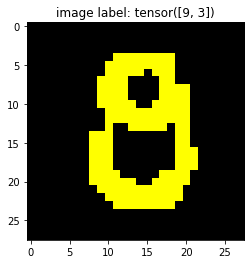

In [0]:
sample_index = 80

plt.imshow(dataset[sample_index][0].permute(1, 2, 0), interpolation='nearest')
plt.title("image label: {}".format(dataset[sample_index][1]))

### Training the neural network

In [0]:
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        # The input size is 28*28. For a standard classification task, the output size should be the same as the number of classes
        self.l_number = nn.Linear(28*28*3, 10)
        # However here we deal with 2 tasks: the network outputs 2 labels, so there are two "last" layers in parallel
        self.l_color = nn.Linear(28*28*3, 7)
        
    def forward(self, inputs):
        h = inputs.view(-1, 28*28*3)
        # Use softmax as the activation function for the last layer(s)
        output_number = F.softmax(self.l_number(h), dim=1)
        output_color = F.softmax(self.l_color(h), dim=1)
        
        return (output_number, output_color)

In [0]:
# Create the model: 
model = Model()

# Choose the hyperparameters for training: 
num_epochs = 10
batch_size = 10

# Use mean squared loss function 
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [0]:
# define a function for training
def train(num_epochs, batch_size, criterion, optimizer, model, dataset):
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.train()
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (images, labels) in train_loader:
            (y_number, y_color) = model(images)
            
            # One-hot encoding or labels so as to calculate MSE error:
            number_onehot = F.one_hot(labels[:,0], 10).float()
            color_onehot = F.one_hot(labels[:,1], 7).float()
            
            loss = criterion(y_number, number_onehot) + criterion(y_color, color_onehot)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        print('Epoch [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, epoch_average_loss))
    return train_error

In [0]:
train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set)

Epoch [1/10], Loss: 0.3875
Epoch [2/10], Loss: 0.3269
Epoch [3/10], Loss: 0.2718
Epoch [4/10], Loss: 0.2545
Epoch [5/10], Loss: 0.2497
Epoch [6/10], Loss: 0.2421
Epoch [7/10], Loss: 0.2412
Epoch [8/10], Loss: 0.2420
Epoch [9/10], Loss: 0.2416
Epoch [10/10], Loss: 0.2392


Text(0.5, 1.0, 'Visualization of convergence')

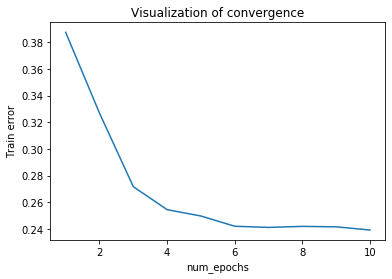

In [0]:
# plot the training error wrt. the number of epochs: 
plt.plot(range(1, num_epochs+1), train_error)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")

### Evaluate the model on the validation set

In [0]:
# Calculate the accuracy to evaluate the model
def accuracy(dataset, model):

    with torch.no_grad():
        number_correct = 0
        color_correct = 0
        both_correct = 0
        dataloader = DataLoader(dataset)
        for images, labels in dataloader:
            images = images.view(-1, 28*28)
            (y_number, y_color) = model(images)
            _, number_predicted = torch.max(y_number.data, 1) 
            number_correct += (number_predicted == labels[:, 0]).sum()
            _, color_predicted = torch.max(y_color.data, 1) 
            color_correct += (color_predicted == labels[:, 1]).sum()
            both_correct += ((color_predicted == labels[:, 1]) and (number_predicted == labels[:, 0])).sum()

    print('Accuracy of the model for numbers : {:.2f} %'.format(100*number_correct.item()/ len(dataset)))
    print('Accuracy of the model for colors : {:.2f} %'.format(100*color_correct.item()/ len(dataset)))
    print('Accuracy of the model for both : {:.2f} %'.format(100*both_correct.item()/ len(dataset)))

In [0]:
accuracy(val_set, model)

Accuracy of the model for numbers : 53.38 %
Accuracy of the model for colors : 50.44 %
Accuracy of the model for both : 27.00 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Prediction: number=4, color=5')

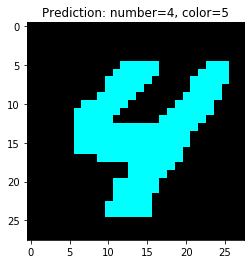

In [0]:
val_index = 66

(image, label) = val_set[val_index]
(y_number, y_color) = model(image)
_, number_prediction = torch.max(y_number.data, 1)
_, color_prediction = torch.max(y_color.data, 1)

plt.imshow(image.permute(1, 2, 0), interpolation='nearest')
plt.title("Prediction: number=%d, color=%d" % (number_prediction, color_prediction))

### Exercise 1: Impact of the architecture of the model
Define your own class `Model` to improve the predictions:

* The convolutional layer can be a good choice to deal with images. Replace nn.Linear with [nn.Conv2d](https://pytorch.org/docs/stable/nn.html#conv2d).
* Try to add more layers (1, 2, 3, more ?)
* Change the number of neurons in hidden layers (5, 10, 20, more ?)
* Try different activation functions such as [sigmoid](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.sigmoid), [tanh](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.tanh), [relu](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu), etc.
* __Your network generates two different outputs, how much weight-sharing (i.e. how many common layers) between these two paths is appropriate?__

### Training the neural network

In [0]:
class my_Model_relu(nn.Module):
    
    def __init__(self,model):
        super(my_Model_relu, self).__init__()
        self.model = model
        # The input size is 28*28. For a standard classification task, the output size should be the same as the number of classes
        self.conv1 = nn.Conv2d(3, 8, 3)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.conv3 = nn.Conv2d(16, 64, 3)
        self.fc1 = nn.Linear(2304, 128)
        self.fc2 = nn.Linear(7744, 128)
        self.l_number = nn.Linear(128, 10)
        # However here we deal with 2 tasks: the network outputs 2 labels, so there are two "last" layers in parallel
        self.l_color = nn.Linear(128, 7)
    def forward(self, inputs):
        # h = inputs.view(-1, 28*28*3)
        h = inputs
        # Use softmax as the activation function for the last layer(s)
        if self.model == "2_layers":
          x= self.conv1(h)
          x = F.relu(x)
          x = self.conv2(x)
          x = F.max_pool2d(x, 2)
          # x = self.dropout1(x)
          x = torch.flatten(x, 1)
          x = self.fc1(x)
          x = F.relu(x)
        elif self.model == "3_layers":
          x= self.conv1(h)
          x = F.relu(x)
          x = self.conv2(x)
          x = F.relu(x)
          x = self.conv3(x)
          x = F.max_pool2d(x, 2)
          # x = self.dropout1(x)
          x = torch.flatten(x, 1)
          x = self.fc2(x)
          x = F.relu(x)         
        
        
        output_number = F.softmax(self.l_number(x), dim=1)
        output_color = F.softmax(self.l_color(x), dim=1)
        
        return (output_number, output_color)

In [0]:
class my_Model_tanh(nn.Module):
    
    def __init__(self,model):
        super(my_Model_tanh, self).__init__()
        self.model = model
        # The input size is 28*28. For a standard classification task, the output size should be the same as the number of classes
        self.conv1 = nn.Conv2d(3, 8, 3)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.conv3 = nn.Conv2d(16, 64, 3)
        self.fc1 = nn.Linear(2304, 128)
        self.fc2 = nn.Linear(7744, 128)
        self.l_number = nn.Linear(128, 10)
        # However here we deal with 2 tasks: the network outputs 2 labels, so there are two "last" layers in parallel
        self.l_color = nn.Linear(128, 7)
    def forward(self, inputs):
        # h = inputs.view(-1, 28*28*3)
        h = inputs
        # Use softmax as the activation function for the last layer(s)
        if self.model == "2_layers":
          x= self.conv1(h)
          x = F.tanh(x)
          x = self.conv2(x)
          x = F.max_pool2d(x, 2)
          # x = self.dropout1(x)
          x = torch.flatten(x, 1)
          x = self.fc1(x)
          x = F.tanh(x)
        elif self.model == "3_layers":
          x= self.conv1(h)
          x = F.tanh(x)
          x = self.conv2(x)
          x = F.tanh(x)
          x = self.conv3(x)
          x = F.max_pool2d(x, 2)
          # x = self.dropout1(x)
          x = torch.flatten(x, 1)
          x = self.fc2(x)
          x = F.tanh(x)         
        
        
        output_number = F.softmax(self.l_number(x), dim=1)
        output_color = F.softmax(self.l_color(x), dim=1)
        
        return (output_number, output_color)

In [0]:
class my_Model_sigmoid(nn.Module):
    
    def __init__(self,model):
        super(my_Model_sigmoid, self).__init__()
        self.model = model
        # The input size is 28*28. For a standard classification task, the output size should be the same as the number of classes
        self.conv1 = nn.Conv2d(3, 8, 3)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.conv3 = nn.Conv2d(16, 64, 3)
        self.fc1 = nn.Linear(2304, 128)
        self.fc2 = nn.Linear(7744, 128)
        self.l_number = nn.Linear(128, 10)
        # However here we deal with 2 tasks: the network outputs 2 labels, so there are two "last" layers in parallel
        self.l_color = nn.Linear(128, 7)
    def forward(self, inputs):
        # h = inputs.view(-1, 28*28*3)
        h = inputs
        # Use softmax as the activation function for the last layer(s)
        if self.model == "2_layers":
          x= self.conv1(h)
          x = F.sigmoid(x)
          x = self.conv2(x)
          x = F.max_pool2d(x, 2)
          # x = self.dropout1(x)
          x = torch.flatten(x, 1)
          x = self.fc1(x)
          x = F.sigmoid(x)
        elif self.model == "3_layers":
          x= self.conv1(h)
          x = F.sigmoid(x)
          x = self.conv2(x)
          x = F.sigmoid(x)
          x = self.conv3(x)
          x = F.max_pool2d(x, 2)
          # x = self.dropout1(x)
          x = torch.flatten(x, 1)
          x = self.fc2(x)
          x = F.sigmoid(x)         
        
        
        output_number = F.softmax(self.l_number(x), dim=1)
        output_color = F.softmax(self.l_color(x), dim=1)
        
        return (output_number, output_color)

Epoch [1/10], Loss: 0.0237
Epoch [2/10], Loss: 0.0089
Epoch [3/10], Loss: 0.0063
Epoch [4/10], Loss: 0.0050
Epoch [5/10], Loss: 0.0040
Epoch [6/10], Loss: 0.0033
Epoch [7/10], Loss: 0.0027
Epoch [8/10], Loss: 0.0023
Epoch [9/10], Loss: 0.0019
Epoch [10/10], Loss: 0.0017
Accuracy of the model for numbers : 97.47 %
Accuracy of the model for colors : 100.00 %
Accuracy of the model for both : 97.47 %
None
Epoch [1/10], Loss: 0.0176
Epoch [2/10], Loss: 0.0061
Epoch [3/10], Loss: 0.0039
Epoch [4/10], Loss: 0.0028
Epoch [5/10], Loss: 0.0022
Epoch [6/10], Loss: 0.0018
Epoch [7/10], Loss: 0.0014
Epoch [8/10], Loss: 0.0011
Epoch [9/10], Loss: 0.0009
Epoch [10/10], Loss: 0.0008
Accuracy of the model for numbers : 98.33 %
Accuracy of the model for colors : 100.00 %
Accuracy of the model for both : 98.33 %
None


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [1/10], Loss: 0.1022
Epoch [2/10], Loss: 0.0612
Epoch [3/10], Loss: 0.0273
Epoch [4/10], Loss: 0.0179
Epoch [5/10], Loss: 0.0143
Epoch [6/10], Loss: 0.0121
Epoch [7/10], Loss: 0.0106
Epoch [8/10], Loss: 0.0095
Epoch [9/10], Loss: 0.0086
Epoch [10/10], Loss: 0.0079
Accuracy of the model for numbers : 95.26 %
Accuracy of the model for colors : 99.98 %
Accuracy of the model for both : 95.25 %
None
Epoch [1/10], Loss: 0.1013
Epoch [2/10], Loss: 0.0466
Epoch [3/10], Loss: 0.0224
Epoch [4/10], Loss: 0.0163
Epoch [5/10], Loss: 0.0136
Epoch [6/10], Loss: 0.0118
Epoch [7/10], Loss: 0.0105
Epoch [8/10], Loss: 0.0095
Epoch [9/10], Loss: 0.0086
Epoch [10/10], Loss: 0.0079
Accuracy of the model for numbers : 95.14 %
Accuracy of the model for colors : 100.00 %
Accuracy of the model for both : 95.14 %
None


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch [1/10], Loss: 0.2051
Epoch [2/10], Loss: 0.1357
Epoch [3/10], Loss: 0.0940
Epoch [4/10], Loss: 0.0912
Epoch [5/10], Loss: 0.0903
Epoch [6/10], Loss: 0.0896
Epoch [7/10], Loss: 0.0887
Epoch [8/10], Loss: 0.0876
Epoch [9/10], Loss: 0.0861
Epoch [10/10], Loss: 0.0845
Accuracy of the model for numbers : 24.37 %
Accuracy of the model for colors : 100.00 %
Accuracy of the model for both : 24.37 %
None
Epoch [1/10], Loss: 0.2095
Epoch [2/10], Loss: 0.2087
Epoch [3/10], Loss: 0.2080
Epoch [4/10], Loss: 0.2046
Epoch [5/10], Loss: 0.1500
Epoch [6/10], Loss: 0.0951
Epoch [7/10], Loss: 0.0913
Epoch [8/10], Loss: 0.0904
Epoch [9/10], Loss: 0.0897
Epoch [10/10], Loss: 0.0890
Accuracy of the model for numbers : 13.30 %
Accuracy of the model for colors : 100.00 %
Accuracy of the model for both : 13.30 %
None


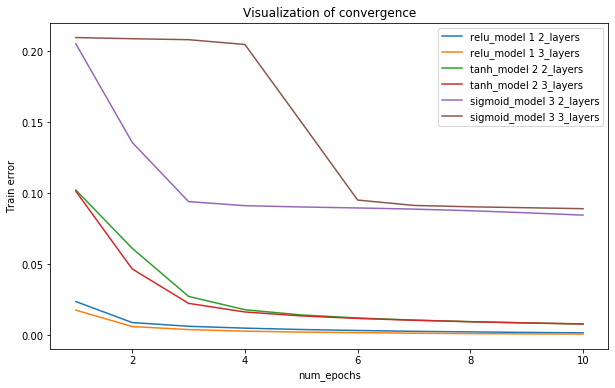

In [0]:
models =      {"relu_model 1": my_Model_relu,
               "tanh_model 2": my_Model_tanh,
               "sigmoid_model 3": my_Model_sigmoid}
num_epochs = 10
batch_size = 10
criterion = nn.MSELoss()
plt.figure(figsize=(10, 6))
titles = []
for key in models.keys():
  for model in ["2_layers",'3_layers']:
    titles.append(key+" "+model)
    model = models[key](model)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set)
    model.eval() # set the model to test mode
    plt.plot(range(1, num_epochs+1), train_error)
    with torch.no_grad():
      print(accuracy(val_set, model,66))
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")
plt.legend(titles)
plt.show()

### Evaluate the model on the validation set

In [0]:
# Calculate the accuracy to evaluate the model
def accuracy(dataset, model,k):

    with torch.no_grad():
        number_correct = 0
        color_correct = 0
        both_correct = 0
        dataloader = DataLoader(dataset)
  #      i=0
        for images, labels in dataloader:
            # print(images.shape)
            # images = images.view(-1, 28*28)
            (y_number, y_color) = model(images)
            _, number_predicted = torch.max(y_number.data, 1) 
            number_correct += (number_predicted == labels[:, 0]).sum()
            _, color_predicted = torch.max(y_color.data, 1) 
            color_correct += (color_predicted == labels[:, 1]).sum()
            both_correct += ((color_predicted == labels[:, 1]) and (number_predicted == labels[:, 0])).sum()
#            if i == k:
#             plt.imshow(images[0].permute(1, 2, 0), interpolation='nearest')
#              plt.title("Prediction: number=%d, color=%d" % (number_predicted, color_predicted))
 #           i+=1

    print('Accuracy of the model for numbers : {:.2f} %'.format(100*number_correct.item()/ len(dataset)))
    print('Accuracy of the model for colors : {:.2f} %'.format(100*color_correct.item()/ len(dataset)))
    print('Accuracy of the model for both : {:.2f} %'.format(100*both_correct.item()/ len(dataset)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Accuracy of the model for numbers : 97.63 %
Accuracy of the model for colors : 100.00 %
Accuracy of the model for both : 97.63 %


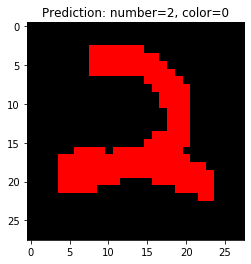

In [0]:
accuracy(val_set, model,66)

### Exercise 2: Impact of the optimizer
Retrain the model by using different parameters of the optimizer; you can change its parameters in the cell initializing it, after the definition of your model.

* Use different batch sizes, from 10 to 1 000 for instance
* Try different values of the learning rate (between 0.001 and 10), and see how these impact the training process. Do all network architectures react the same way to different learning rates?
* Change the duration of the training by increasing the number of epochs
* Try other optimizers, such as [Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) or [RMSprop](https://pytorch.org/docs/stable/optim.html?highlight=rmsprop#torch.optim.RMSprop)

### Training the neural network

Epoch [1/10], Loss: 0.0178
Epoch [2/10], Loss: 0.0066
Epoch [3/10], Loss: 0.0042
Epoch [4/10], Loss: 0.0031
Epoch [5/10], Loss: 0.0024
Epoch [6/10], Loss: 0.0018
Epoch [7/10], Loss: 0.0015
Epoch [8/10], Loss: 0.0013
Epoch [9/10], Loss: 0.0011
Epoch [10/10], Loss: 0.0010
Accuracy of the model for numbers : 97.99 %
Accuracy of the model for colors : 100.00 %
Accuracy of the model for both : 97.99 %
None
Epoch [1/10], Loss: 0.0331
Epoch [2/10], Loss: 0.0128
Epoch [3/10], Loss: 0.0101
Epoch [4/10], Loss: 0.0085
Epoch [5/10], Loss: 0.0074
Epoch [6/10], Loss: 0.0067
Epoch [7/10], Loss: 0.0059
Epoch [8/10], Loss: 0.0054
Epoch [9/10], Loss: 0.0049
Epoch [10/10], Loss: 0.0045
Accuracy of the model for numbers : 96.15 %
Accuracy of the model for colors : 99.99 %
Accuracy of the model for both : 96.15 %
None
Epoch [1/10], Loss: 0.0493
Epoch [2/10], Loss: 0.0165
Epoch [3/10], Loss: 0.0132
Epoch [4/10], Loss: 0.0115
Epoch [5/10], Loss: 0.0103
Epoch [6/10], Loss: 0.0093
Epoch [7/10], Loss: 0.0086
Ep

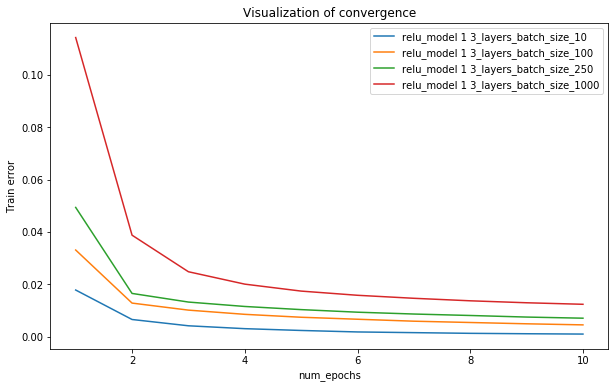

In [0]:
models =      {"relu_model 1": my_Model_relu}
num_epochs = 10
batch_size = 10
criterion = nn.MSELoss()
plt.figure(figsize=(10, 6))
titles = []
for key in models.keys():
  for model2 in ['3_layers']:
    for batch in [10,100,250,1000]:
      batch_size = batch
      titles.append(key+" "+"3_layers" + "_batch_size_"+str(batch_size))
      model = models[key](model2)
      optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
      train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set)
      model.eval() # set the model to test mode
      plt.plot(range(1, num_epochs+1), train_error)
      with torch.no_grad():
        print(accuracy(val_set, model,66))
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")
plt.legend(titles)
plt.show()